# Assignment 1

This code baseline is inspired by and modified from [this great tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

This code can achieve an accuracy of approximately 86.50% on CIFAR-10. Please set up the environment and run your experiments starting from this baseline. You are expected to achieve an accuracy higher than this baseline.

In [1]:
# import some necessary packages
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.datasets as tv_datasets
import torchvision.transforms as tv_transforms


import matplotlib.pyplot as plt

In [2]:
# 残差结构
class Resblock(nn.Module):
  def __init__(self,in_channel,out_channel,downsample=False):
    super().__init__()
    self.in_channel = in_channel
    self.out_channel = out_channel
    self.downsample = downsample
    strides = 2 if self.downsample else 1
    if self.downsample or in_channel!=out_channel:
      self.conv3 = nn.Conv2d(in_channel,out_channel,kernel_size=1,stride=strides,padding=0,bias=False)

    self.conv1 = nn.Conv2d(in_channel,out_channel,kernel_size=3,stride =strides,padding =1,bias=False)
    self.bn1  = nn.BatchNorm2d(out_channel)
    self.relu1 = nn.ReLU(inplace = True)
    self.bn2  = nn.BatchNorm2d(out_channel)
    self.conv2 = nn.Conv2d(out_channel,out_channel,kernel_size=3,stride=1,padding=1,bias=False)
    self.relu2 = nn.ReLU(inplace = True)

  def forward(self,x):
    identity = x
    Y = self.relu1(self.bn1(self.conv1(x)))
    Y = self.bn2(self.conv2(Y))
    if self.downsample or self.in_channel!=self.out_channel:
      identity = self.conv3(identity)
    Y=Y+identity
    return self.relu2(Y)



In [3]:
# some experimental setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_epochs = 128
batch_size = 128
num_workers = 2
print_every = 200

optim_name = "Adam"
optim_kwargs = dict(
    lr=1e-4,
    weight_decay=1e-6,
)

# preprocessing pipeline for input images
transformation = dict()
for data_type in ("train", "test"):
    is_train = data_type=="train"
    transformation[data_type] = tv_transforms.Compose(([
        tv_transforms.RandomRotation(degrees=15),
        tv_transforms.RandomHorizontalFlip(),
        tv_transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    ] if is_train else []) +
    [
        tv_transforms.ToTensor(),
        tv_transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])


In [4]:
# prepare datasets
dataset, loader = {}, {}
for data_type in ("train", "test"):
    is_train = data_type=="train"
    dataset[data_type] = tv_datasets.CIFAR10(
        root="./data", train=is_train, download=True, transform=transformation[data_type],
    )
    loader[data_type] = torch.utils.data.DataLoader(
        dataset[data_type], batch_size=batch_size, shuffle=is_train, num_workers=num_workers,
    )


100%|██████████| 170M/170M [00:15<00:00, 10.7MB/s]


In [ ]:
#残差
class CIFAR_Net_With_Resblock(nn.Module):
    def __init__(self):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.layer1 = Resblock(in_channel=64,  out_channel=128, downsample=True)
        self.layer2 = Resblock(in_channel=128,  out_channel=128, downsample=False)

        self.layer3 = Resblock(in_channel=128, out_channel=256, downsample=True)
        self.layer4 = Resblock(in_channel=256, out_channel=256, downsample=False)

        self.layer5 = Resblock(in_channel=256, out_channel=512, downsample=True)

        self.layer6 = Resblock(in_channel=512, out_channel=512)

        self.final_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256), nn.ReLU(inplace=True), nn.Dropout(0.4),
            nn.Linear(256, 128), nn.ReLU(inplace=True), nn.Dropout(0.4),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.stem(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)

        x = self.final_pool(x)
        x = self.classifier(x)

        return x
net = CIFAR_Net_With_Resblock()

In [6]:
# move to device
net.to(device)

# print the number of parameters
print(f"number of parameters: {sum(p.numel() for p in net.parameters() if p.requires_grad) / 1_000_000:.2f}M")

number of parameters: 11.18M


## Start Training

[epoch=  1, iter=  200] loss: 1.822
[Epoch   1] Validation loss: 1.317, Accuracy: 51.85%
[epoch=  2, iter=  200] loss: 1.271
[Epoch   2] Validation loss: 1.090, Accuracy: 62.23%
[epoch=  3, iter=  200] loss: 1.050
[Epoch   3] Validation loss: 0.897, Accuracy: 69.28%
[epoch=  4, iter=  200] loss: 0.912
[Epoch   4] Validation loss: 0.844, Accuracy: 72.56%
[epoch=  5, iter=  200] loss: 0.819
[Epoch   5] Validation loss: 0.763, Accuracy: 74.76%
[epoch=  6, iter=  200] loss: 0.744
[Epoch   6] Validation loss: 0.657, Accuracy: 77.73%
[epoch=  7, iter=  200] loss: 0.668
[Epoch   7] Validation loss: 0.625, Accuracy: 79.04%
[epoch=  8, iter=  200] loss: 0.628
[Epoch   8] Validation loss: 0.552, Accuracy: 80.81%
[epoch=  9, iter=  200] loss: 0.588
[Epoch   9] Validation loss: 0.538, Accuracy: 81.69%
[epoch= 10, iter=  200] loss: 0.552
[Epoch  10] Validation loss: 0.511, Accuracy: 82.65%
[epoch= 11, iter=  200] loss: 0.518
[Epoch  11] Validation loss: 0.528, Accuracy: 82.53%
[epoch= 12, iter=  20

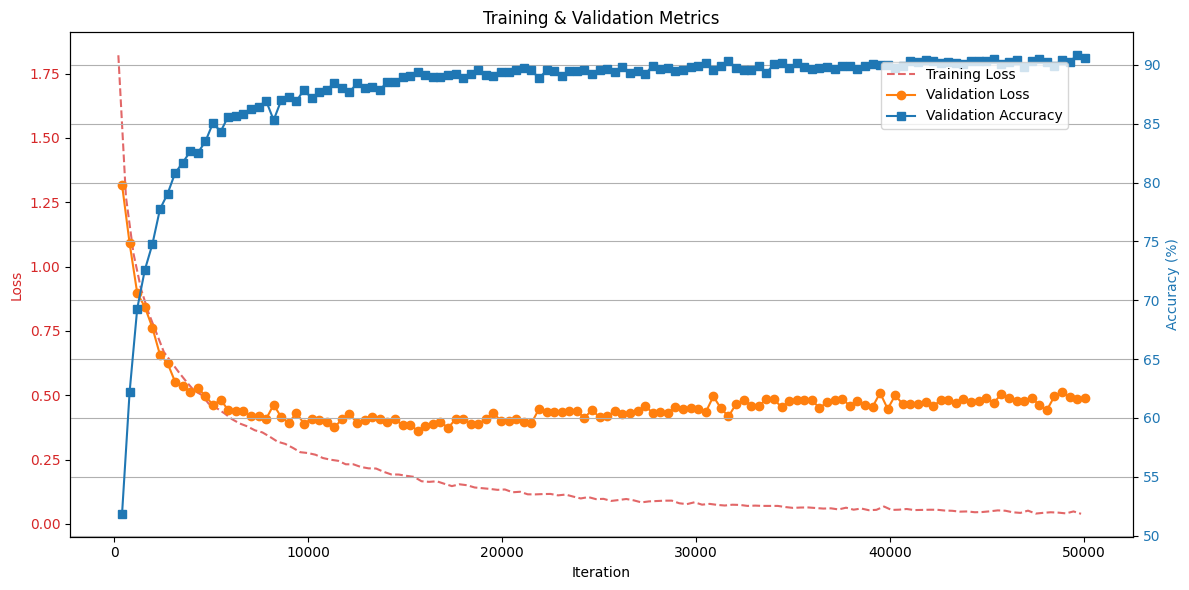

In [ ]:
# the network optimizer
optimizer = getattr(optim, optim_name)(net.parameters(), **optim_kwargs)

# loss function
criterion = nn.CrossEntropyLoss()


loss_history = []
iter_history = []
current_iter = 0
val_loss_history = []
val_acc_history = []
val_iter_history = []

# training loop
net.train()
for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    for i, (img, target) in enumerate(loader["train"]):
        img, target = img.to(device), target.to(device)


        pred = net(img)
        loss = criterion(pred, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        current_iter += 1
        if i % print_every == print_every - 1:
            avg_loss = running_loss / print_every
            print(f"[epoch={epoch + 1:3d}, iter={i + 1:5d}] loss: {running_loss / print_every:.3f}")
            iter_history.append(current_iter)
            loss_history.append(avg_loss)
            running_loss = 0.0

    net.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for img, target in loader["test"]:
            img, target = img.to(device), target.to(device)
            pred = net(img)
            loss = criterion(pred, target)
            val_loss += loss.item()
            total += len(target)
            correct += (torch.argmax(pred, dim=1) == target).sum().item()

    avg_val_loss = val_loss / len(loader["test"])
    accuracy = 100 * correct / total

    print(f"[Epoch {epoch + 1:3d}] Validation loss: {avg_val_loss:.3f}, Accuracy: {accuracy:.2f}%")
    val_iter_history.append(current_iter)
    val_loss_history.append(avg_val_loss)
    val_acc_history.append(accuracy)

print("Finished Training")
# plot
fig, ax1 = plt.subplots(figsize=(12, 6))
plt.title('Training & Validation Metrics')

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss', color='tab:red')
ax1.plot(iter_history, loss_history, color='tab:red', linestyle='--', alpha=0.7, label='Training Loss')
ax1.plot(val_iter_history, val_loss_history, color='tab:orange', marker='o', label='Validation Loss')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy (%)', color='tab:blue')
ax2.plot(val_iter_history, val_acc_history, color='tab:blue', marker='s', label='Validation Accuracy')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))

fig.tight_layout()
plt.grid(True)
plt.savefig('all_metrics_curve.png')

print("\nMetrics curve has been saved to all_metrics_curve.png")

print("\nTraining loss curve has been saved to training_loss_curve.png")

## Evaluating its accuracy

In [8]:
net.eval()
correct, total = 0, 0
with torch.no_grad():
    for img, target in loader["test"]:
        img, target = img.to(device), target.to(device)

        # make prediction
        pred = net(img)

        # accumulate
        total += len(target)
        correct += (torch.argmax(pred, dim=1) == target).sum().item()

print(f"Accuracy of the network on the {total} test images: {100 * correct / total:.2f}%")

Accuracy of the network on the 10000 test images: 90.56%
